## Stock Price Prediction with Sentiment Analysis

In [12]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut

In [13]:
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

In [14]:
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

### Load and Analyze News Data

In [15]:
news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
ut.save_dataframe(daily_sentiment_df, f"{cfg.STOCK_SYMBOL}_daily_sentiment.csv")

Loading and selecting news data...
🎯 Selected target stock: EBAY (3021 articles)
\n📰 Processing news sentiment for EBAY...
Initializing sentiment analyzer with model: ProsusAI/finbert
Using device: cpu
Analyzer initialized successfully.
Analyzing 3021 headlines in batches of 32...


  0%|          | 0/95 [00:00<?, ?it/s]

\nSentiment distribution:\n Sentiment
neutral     1717
positive     694
negative     610
Name: count, dtype: int64
\n📊 Aggregating daily sentiment scores...
DataFrame saved to EBAY_daily_sentiment.csv


### Fetch Stock Data and Calculate Technical Indicators

In [16]:
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)
stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
tech_data = dp.calculate_technical_indicators(stock_data)

\n📈 Fetching stock data for EBAY...
Successfully fetched 2430 days of data.


### Prepare Data for LSTM Models

In [17]:
print("\\n--- Running Simple LSTM Model ---")
X_train_base, X_test_base, y_train_base, y_test_base, scaler_base = mdl.prepare_data_for_lstm(
    tech_data, cfg.BASELINE_FEATURES, cfg.BASELINE_TARGET, cfg.SEQUENCE_LENGTH, cfg.TEST_SIZE
)

baseline_model = mdl.build_lstm_model((X_train_base.shape[1], X_train_base.shape[2]))
baseline_model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
baseline_history = baseline_model.fit(
    X_train_base, y_train_base, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running Simple LSTM Model ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0308 - mae: 0.1376 - val_loss: 0.0053 - val_mae: 0.0542 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0080 - mae: 0.0692 - val_loss: 0.0041 - val_mae: 0.0447 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0072 - mae: 0.0650 - val_loss: 0.0039 - val_mae: 0.0433 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0065 - mae: 0.0596 - val_loss: 0.0035 - val_mae: 0.0397 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0058 - mae: 0.0581 - val_loss: 0.0034 - val_mae: 0.0388 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0056 - mae: 0.0564 - val_loss: 0.0033 - val_mae: 0.0384 - learning_rate: 0.0010
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0057 - mae: 0.0565 - val_loss: 0.0035 - val_mae: 0.0404 - learning_rate: 0.0010
Epoch 8/10
48

#### Evaluate Baseline Model

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


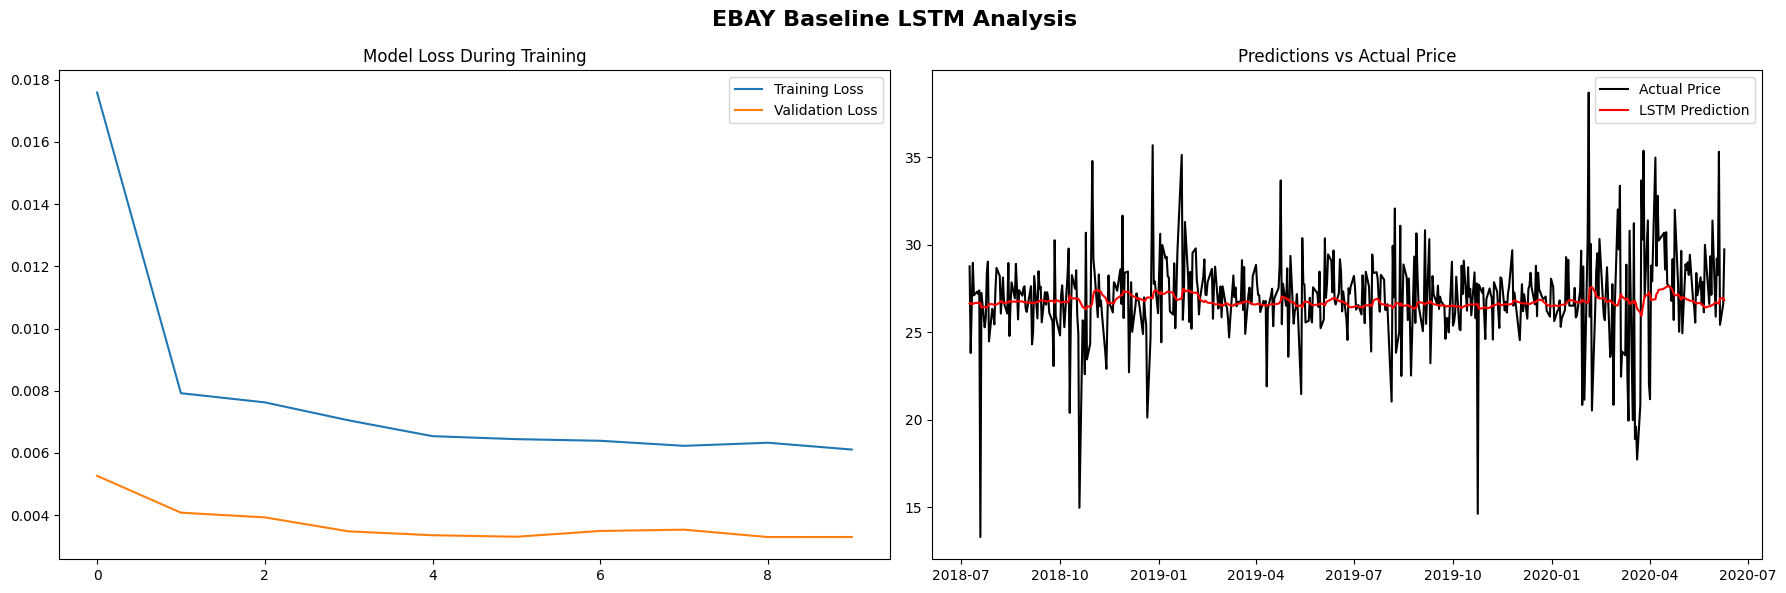

In [18]:
baseline_predictions = baseline_model.predict(X_test_base)
close_scaler = MinMaxScaler().fit(tech_data[['Close']])  # Scaler for close price only
y_test_base_scaled = close_scaler.inverse_transform(y_test_base.reshape(-1, 1))
base_preds_scaled = close_scaler.inverse_transform(baseline_predictions)
baseline_metrics = ut.calculate_metrics(y_test_base_scaled, base_preds_scaled, 'Simple LSTM')
test_dates_base = tech_data.index[-len(y_test_base_scaled):]
ut.plot_baseline_results(baseline_history, y_test_base_scaled, base_preds_scaled, test_dates_base, cfg.STOCK_SYMBOL)


### Sentiment-Enhanced LSTM Model

In [19]:
print("\\n--- Running Sentiment-Enhanced Model ---")
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = mdl.prepare_data_for_lstm(
    enhanced_full_data, cfg.ENHANCED_FEATURES, cfg.ENHANCED_TARGET, cfg.SEQUENCE_LENGTH, cfg.TEST_SIZE
)

enhanced_model = mdl.build_lstm_model((X_train_enh.shape[1], X_train_enh.shape[2]))
enhanced_model.summary()

enhanced_history = enhanced_model.fit(
    X_train_enh, y_train_enh, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running Sentiment-Enhanced Model ---
\n🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2417, 16)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0374 - mae: 0.1496 - val_loss: 0.0038 - val_mae: 0.0426 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0086 - mae: 0.0712 - val_loss: 0.0040 - val_mae: 0.0438 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0079 - mae: 0.0693 - val_loss: 0.0036 - val_mae: 0.0405 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0068 - mae: 0.0635 - val_loss: 0.0035 - val_mae: 0.0397 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0071 - mae: 0.0647 - val_loss: 0.0035 - val_mae: 0.0399 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0063 - mae: 0.0594 - val_loss: 0.0034 - val_mae: 0.0388 - learning_rate: 0.0010
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0061 - mae: 0.0583 - val_loss: 0.0037 - val_mae: 0.0423 - learning_rate: 0.0010
Epoch 8/10
48

#### Evaluate Sentiment-Enhanced Model

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


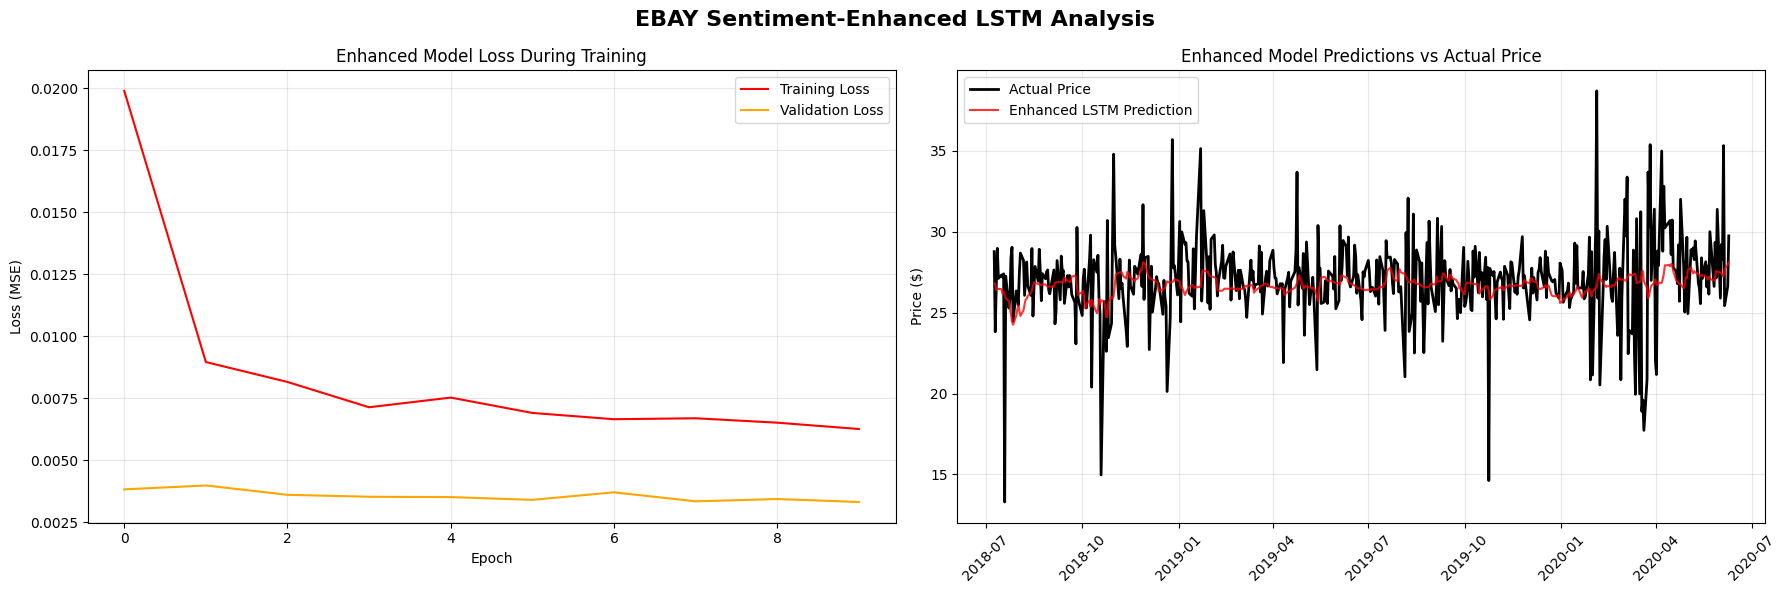

In [20]:
enhanced_predictions = enhanced_model.predict(X_test_enh)
y_test_enh_scaled = close_scaler.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = close_scaler.inverse_transform(enhanced_predictions)
enhanced_metrics = ut.calculate_metrics(y_test_enh_scaled, enh_preds_scaled, 'Enhanced LSTM')
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled):]
ut.plot_enhanced_results(enhanced_history, y_test_enh_scaled, enh_preds_scaled, test_dates_enh, cfg.STOCK_SYMBOL)

### Final Performance Comparison

In [21]:
naive_preds = np.roll(y_test_base_scaled, 1)
naive_preds[0] = y_test_base_scaled[0]
naive_metrics = ut.calculate_metrics(y_test_base_scaled, naive_preds, 'Naive Baseline')
all_metrics_df = pd.DataFrame([baseline_metrics, enhanced_metrics, naive_metrics]).round(4)
print("\\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 60)
print(all_metrics_df.to_string(index=False))

\n📊 COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------
         Model   RMSE    MAE  Directional_Accuracy
   Simple LSTM 2.6173 1.7632               32.7122
 Enhanced LSTM 2.6526 1.8064               49.8965
Naive Baseline 3.6269 2.4971               33.1263


### Plot Results

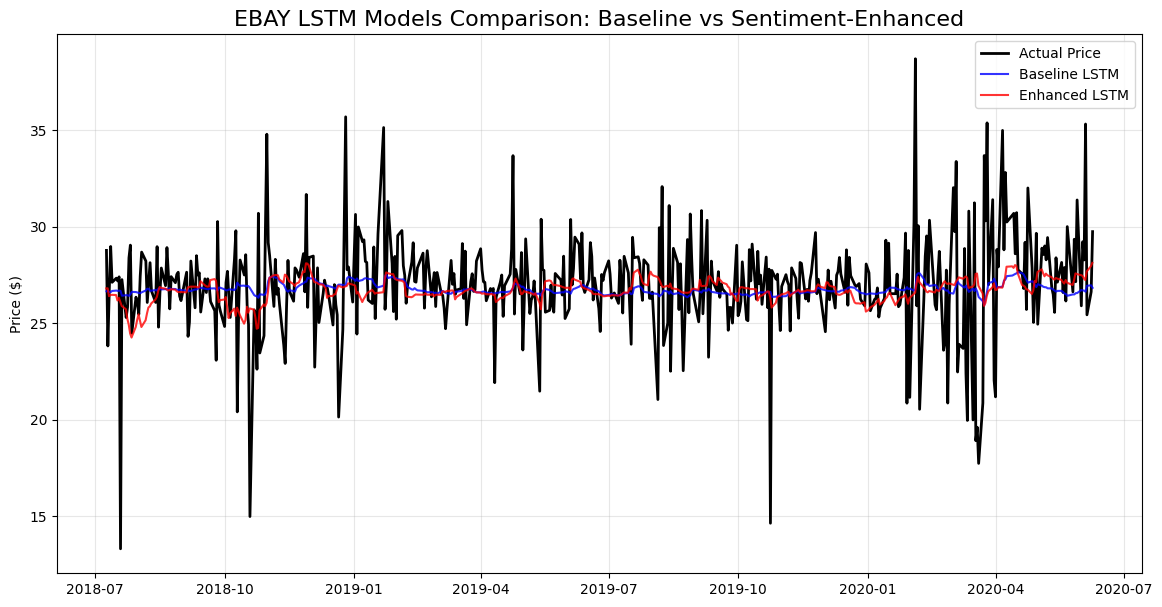

In [22]:
# Plot Comparison
ut.plot_comparison_results(
    y_test_base_scaled, base_preds_scaled,
    y_test_enh_scaled, enh_preds_scaled,
    test_dates_base, test_dates_enh,
    cfg.STOCK_SYMBOL
)